In [229]:
%pip install numpy scipy matplotlib
import numpy as np
from scipy.sparse import csr_matrix, rand, eye, tril, triu, coo_matrix, diags
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 5)

Note: you may need to restart the kernel to use updated packages.


A random sparse M-matrix:

86


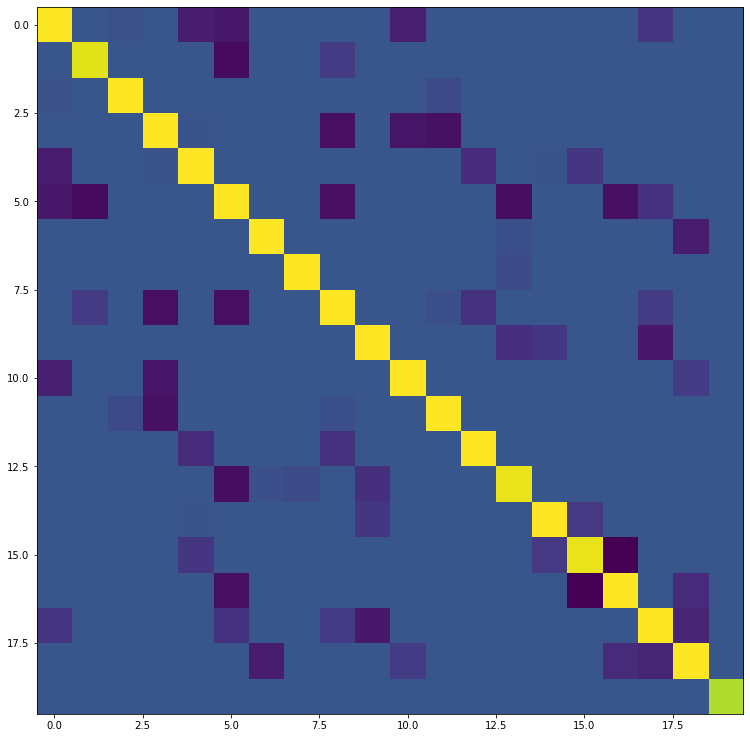

In [136]:
n = 20
density = 0.1
A = csr_matrix(-np.abs(rand(n, n, density)))
A = csr_matrix(A + A.T)
mine = min(np.linalg.eigvals(A.toarray()))
A = csr_matrix(A - mine * 1.1 * eye(n))
plt.figure(figsize=(13,13)).gca().imshow(A.toarray())
print(len(A.data))

The dense LU algorithm without pivoting, in i,k,j order.  As discussed in Saad, in exact arithmetic the factorization of an M-matrix will not breakdown without pivoting:

In [197]:
def lu_ikj(A):
    n = A.shape[0]
    LU = A.toarray()
    for i in range(n):
        for k in range(i):
            LU[i,k] /= LU[k,k]
            for j in range(k+1,n):
                LU[i,j] -= LU[i,k] * LU[k,j]
    return LU

The sparsity pattern of LU: there are more non-zeros than in A.  The non-zeros tend to fill in towards the diagonal: reordering a matrix to reduce fill in can make an exact LU decompostion more efficient, but for some matrices (3D PDEs) the fill in will almost always too much in large matrices for sparse direct methods to be the best choice, like we saw in our first activity.

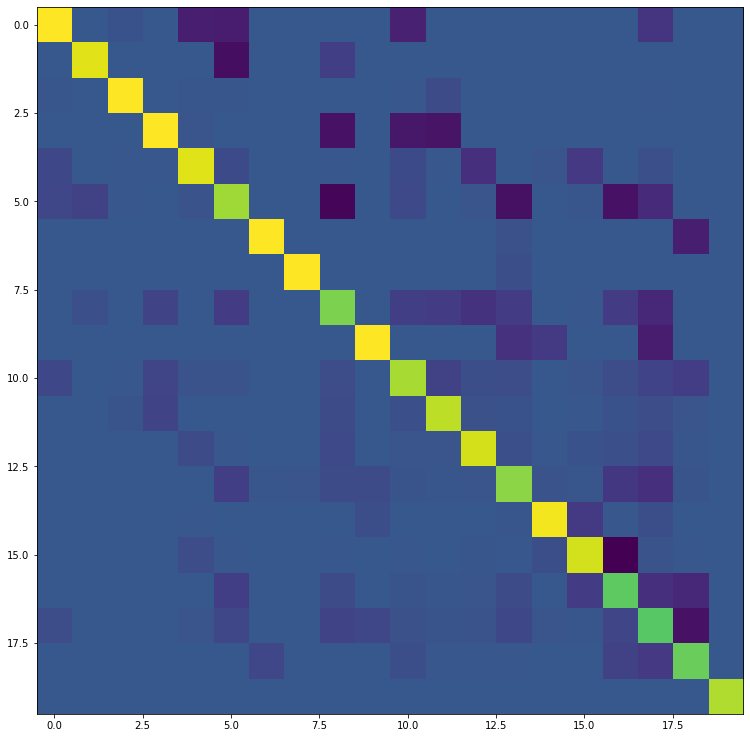

In [198]:
LU = lu_ikj(A)
plt.figure(figsize=(13,13)).gca().imshow(LU)

In [199]:
def get_factors(A):
    n = A.shape[0]
    if isinstance(A, np.ndarray):
        n = A.shape[0]
        L = np.tril(A,-1).copy()
        U = np.triu(A).copy()
        L[range(n), range(n)] = 1
    else:
        L = csr_matrix(tril(A,-1).copy())
        U = csr_matrix(triu(A).copy())
        for i in range(n):
            L[i,i] = 1.
    return L, U
        

Demonstrating that the factors are in fact a factorization of A:

In [152]:
L, U = get_factors(LU)

print(np.linalg.norm(L @ U - A.toarray()))

1.172527055286414e-15


Comparing the storage size of the filled-in matrix to the original.

In [200]:
LUsparse = csr_matrix(LU)
print(len(LUsparse.data))
print(len(A.data))

186
86


Incomplete factorization using the same sparsity pattern as A: the same loops, just indirectly referenced and without introducing new nonzeros in the `LU[i,j] -= LU[i,k] * LU[k,j]` step.

In [203]:
def ilu0_ikj(A):
    n = A.shape[0]
    LU = csr_matrix(A.copy())
    for i in range(n):
        for l in range(A.indptr[i], A.indptr[i+1]):
            k = A.indices[l]
            if k >= i:
                break
            LU[i,k] /= LU[k,k]
            for m in range(l + 1, A.indptr[i+1]):
                j = A.indices[m]
                LU[i,j] -= LU[i,k] * LU[k,j]
    return LU

Demonstrating that the storange is the same:

86


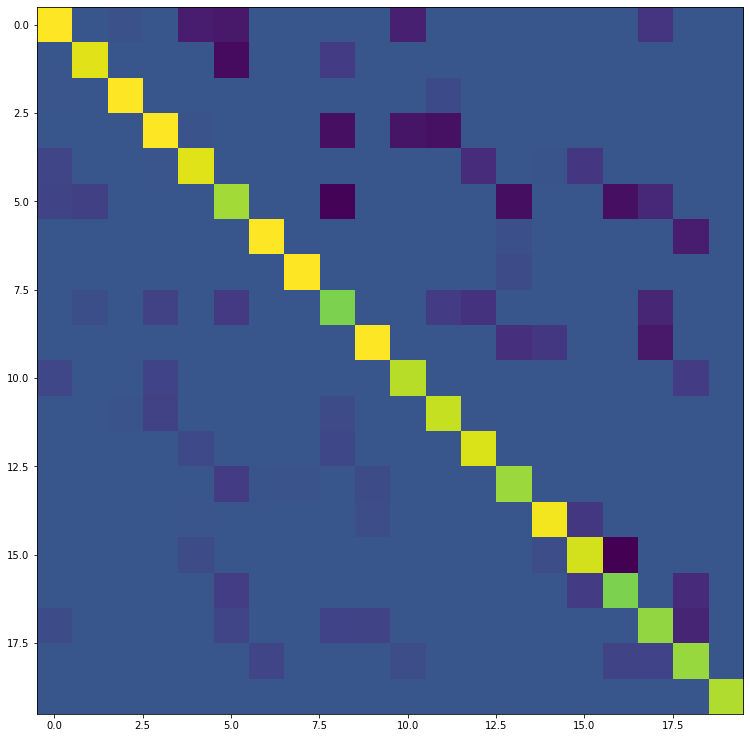

In [204]:
ILU0 = ilu0_ikj(A)
print(len(ILU0.data))
plt.figure(figsize=(13,13)).gca().imshow(ILU0.toarray())

Looking at the residual between the product of the incomplete factor and A:  Notice that R0 is nonzero only outside of the sparsity pattern of A.

1.5491612185851558
-4.440892098500626e-16
0.4361819303565321


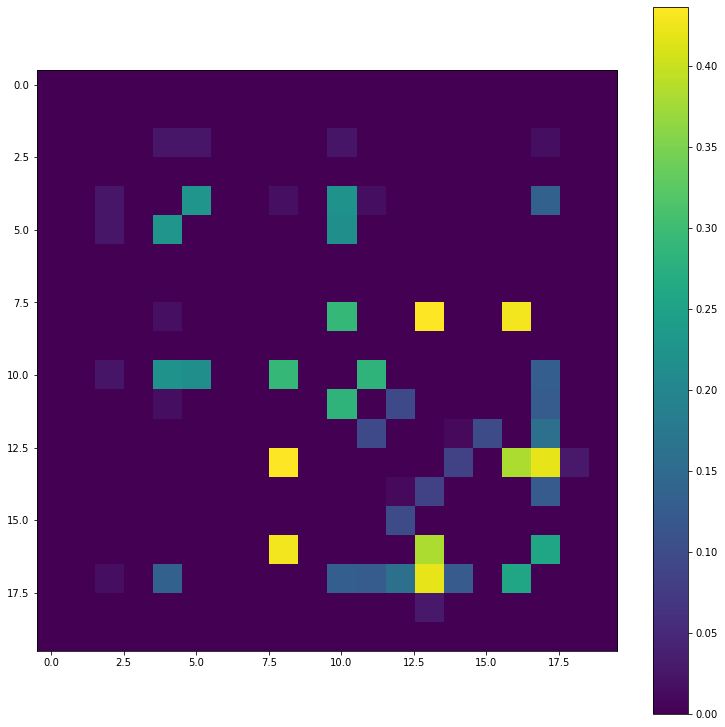

In [205]:
IL0, IU0 = get_factors(ILU0)
R0 = IL0 @ IU0 - A
print(np.linalg.norm(R0.toarray()))
print(np.min(R0.toarray()))
print(np.max(R0.toarray()))
im = plt.figure(figsize=(13,13)).gca().imshow(np.abs(R0.toarray()))
plt.colorbar(im)

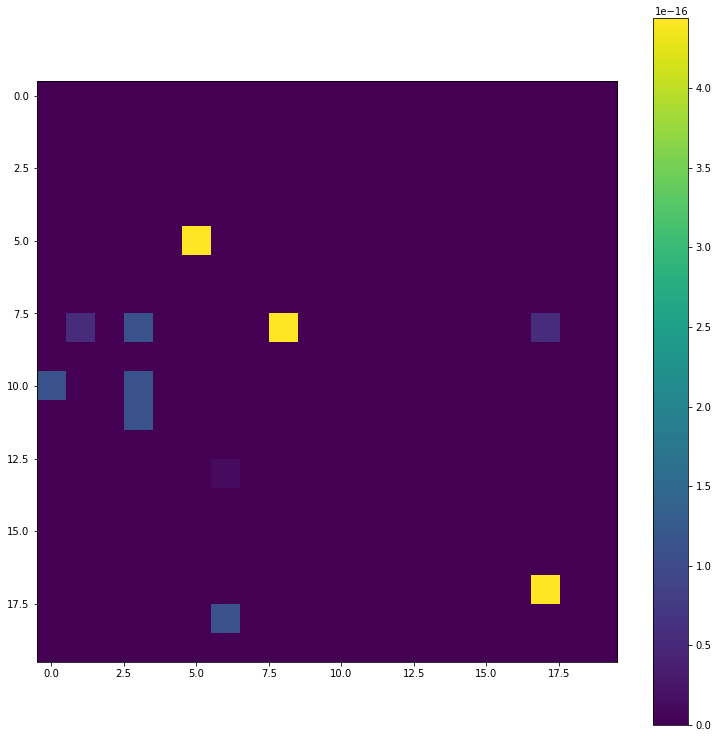

In [164]:
ILU0nz = ILU0.toarray() != 0.
R0isectILU0nz = ILU0nz * R0.toarray()
im = plt.figure(figsize=(13,13)).gca().imshow(np.abs(R0isectILU0nz))
plt.colorbar(im)

ILU(p) with p levels of fill:

- for p iterations, simulate the incomplete factorization process introducing new nonzeros only when they are due to the product of existing non-zeros
- follow the same steps as before using the new sparsity pattern

More storage is required, the factorization takes more time to set up, but the incomplete factorization is more accurate because the residual is smaller

In [195]:
def ilu_ikj(A, p):
    n = A.shape[0]
    LU = csr_matrix(A.copy())
    for s in range(p): # symbolic stage
        LUs = LU.copy()
        for i in range(n):
            for l in range(LU.indptr[i], LU.indptr[i+1]):
                k = LU.indices[l]
                if k >= i:
                    break
                kindices = [LU.indices[m] for m in range(LU.indptr[k], LU.indptr[k+1])]
                for j in kindices:
                    LUs[i,j] = LU[i,j] # introducting a nonzero at LU[i,j] if it wasn't already there
        LU = LUs
    for i in range(n): # numerical stage
        for l in range(LU.indptr[i], LU.indptr[i+1]):
            k = LU.indices[l]
            if k >= i:
                break
            LU[i,k] /= LU[k,k]
            for m in range(l + 1, LU.indptr[i+1]):
                j = LU.indices[m]
                LU[i,j] -= LU[i,k] * LU[k,j]
    return LU

165


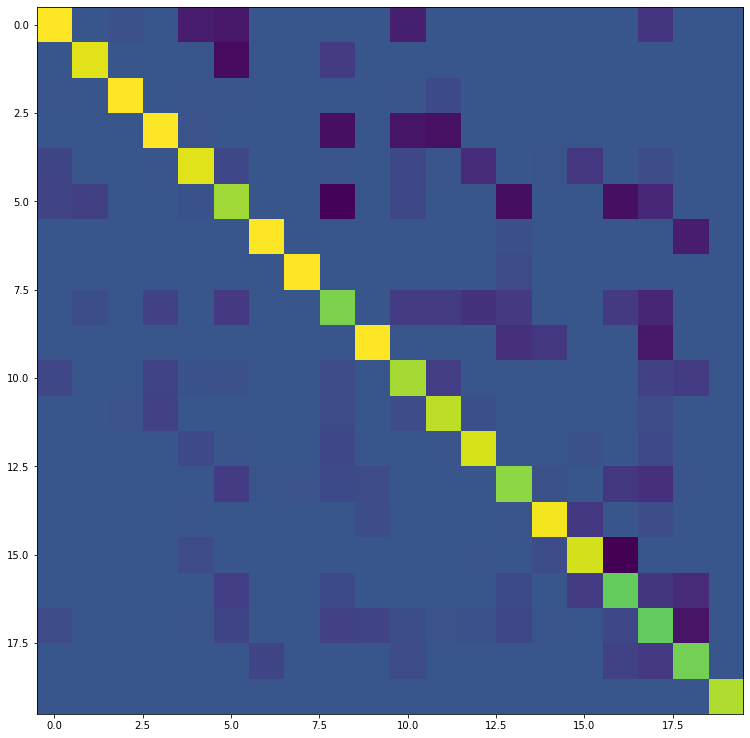

In [206]:
ILU1 = ilu_ikj(A, 1)
print(len(ILU1.data))
plt.figure(figsize=(13,13)).gca().imshow(ILU1.toarray())

The residual with level-of-fill p is always outside of the sparsity pattern of the incomplete factors:

0.49657804056860266
-8.881784197001252e-16
0.16762658441617914


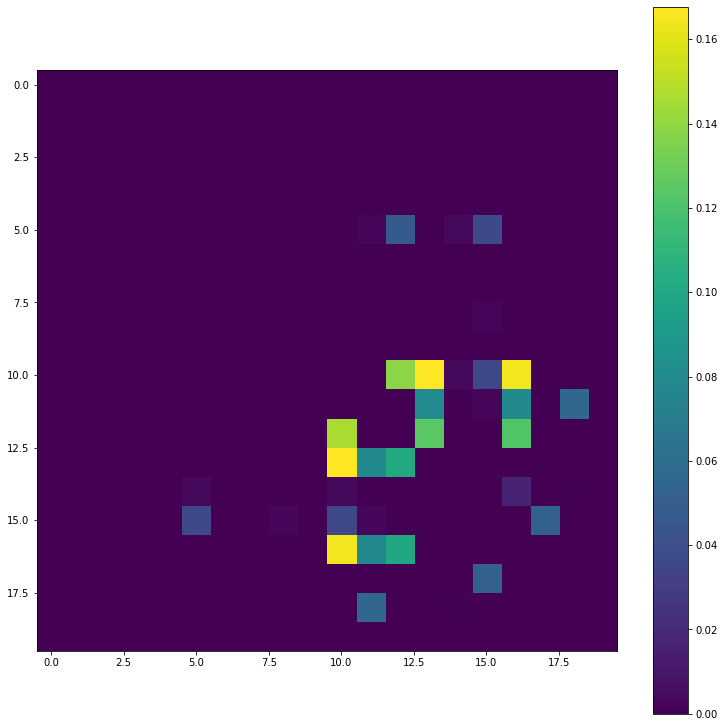

In [207]:
IL1, IU1 = get_factors(ILU1)
R1 = IL1 @ IU1 - A
print(np.linalg.norm(R1.toarray()))
print(np.min(R1.toarray()))
print(np.max(R1.toarray()))
im = plt.figure(figsize=(13,13)).gca().imshow(np.abs(R1.toarray()))
plt.colorbar(im)

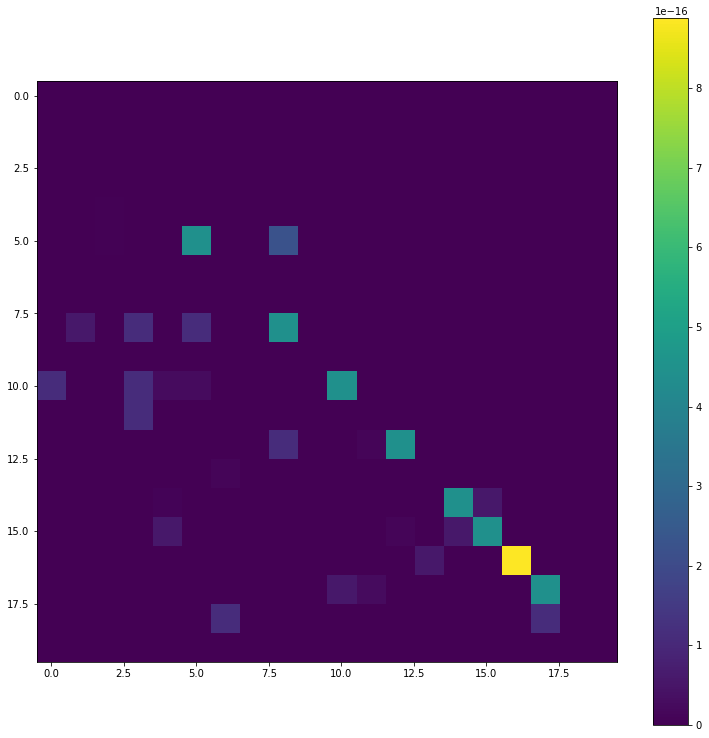

In [166]:
ILU1nz = ILU1.toarray() != 0.
R1isectILU1nz = ILU1nz * R1.toarray()
im = plt.figure(figsize=(13,13)).gca().imshow(np.abs(R1isectILU1nz))
plt.colorbar(im)

Charting the tradeoff in fill vs. residual size

ILU(p) will be exact for a matrix A with adjacency graph with radius p-1

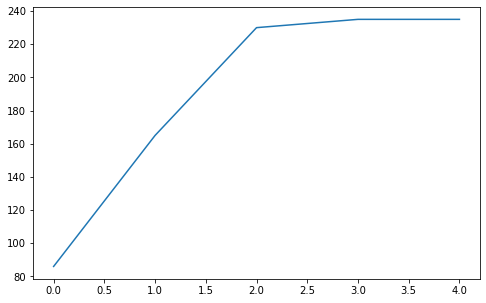

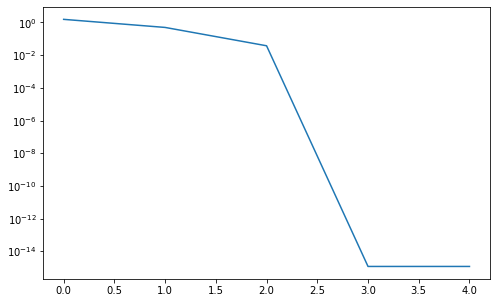

In [212]:
nnzs = []
Rnorms = []
S = list(range(0,5))
for s in S:
    ILU = ilu_ikj(A, s)
    nnzs.append(len(ILU.data))
    IL, IU = get_factors(ILU)
    R = IL @ IU - A
    Rnorms.append(np.linalg.norm(R.toarray()))
plt.plot(S, nnzs)
plt.figure().gca().semilogy(S, Rnorms)
    

Visualizing which elements in the matrix are added as the level of fill increases:

In [215]:
def lu_fill(A):
    n = A.shape[0]
    LU = A.toarray()
    F = np.ndarray(A.shape)
    F[:] = n
    for i in range(n):
        for l in range(A.indptr[i], A.indptr[i+1]):
            j = A.indices[l]
            F[i,j] = 0
    maxv = 0
    for i in range(n):
        for k in range(i):
            for j in range(k+1,n):
                F[i,j] = min(F[i,j], max(F[i,k],F[k,j]) + 1)
                if F[i,j] < n:
                    maxv = max(maxv, int(F[i,j]))
    return F, maxv

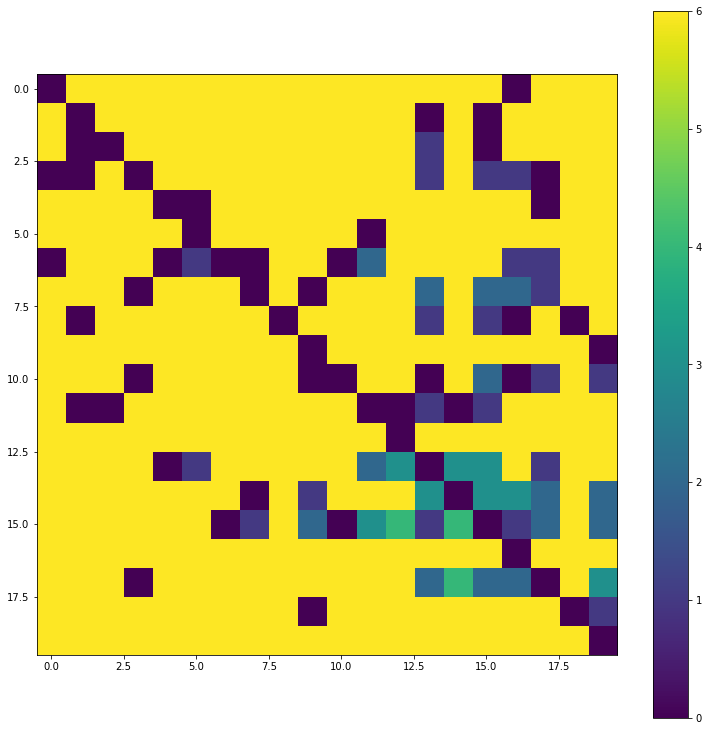

In [261]:
F, maxv = lu_fill(A)
im = plt.figure(figsize=(13,13)).gca().imshow(F, vmin=0, vmax=maxv+1)
plt.colorbar(im)

Comparing the magnitude of entries in the factorization to their level: M-matrix they tend to decrease

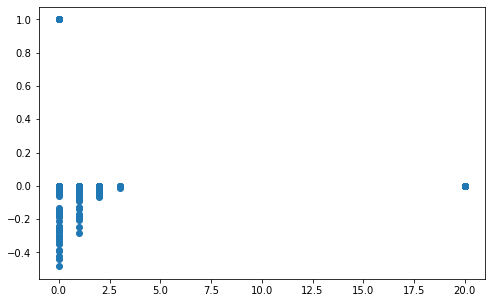

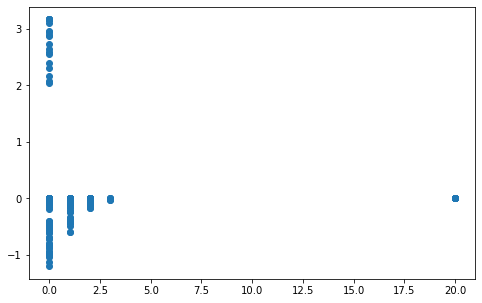

In [227]:
Lvals = {}
Uvals = {}
for i in range(maxv+1):
    Lvals[i] = []
    Uvals[i] = []
for v,f in zip(L.ravel(), F.ravel()):
    if v != 0.:
        Lvals[int(f)].append(v)


plt.scatter(F.ravel(), L.ravel())
plt.figure()
plt.scatter(F.ravel(), U.ravel())

For a general indefinite matrix, the magnitude of the entries doesn't correlate with fill as well: a more sophisticated strategy is needed than level of fill, like thresholding (ILUT) or thresholding with pivoting (ILUTP)

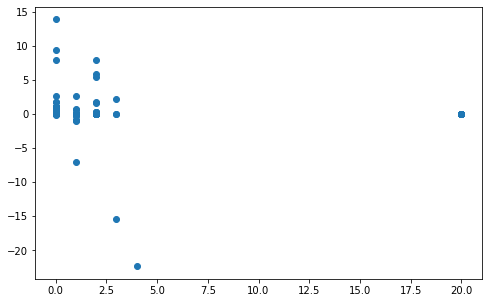

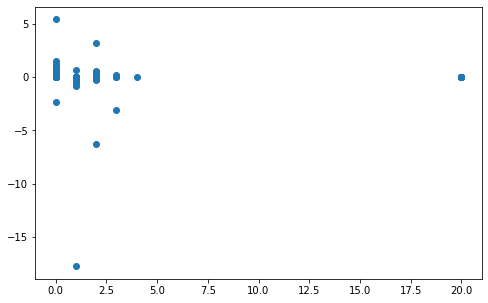

In [272]:
A = rand(n, n, density) + diags(np.random.rand(n))

LU = lu_ikj(A)
L, U = get_factors(LU)
F, maxv = lu_fill(A)

plt.scatter(F.ravel(), L.ravel())
plt.figure()
plt.scatter(F.ravel(), U.ravel())